In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image as im
from matplotlib.pyplot import imshow
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import struct
import pickle
from os.path import join
from array import array
import platform
%matplotlib inline

In [58]:
def read_mnist_dataset(data_filepath, labels_filepath):
    """
    This function will read the mnist dataset from data file and label file which are binary file and return
    data and labels as arrays
    """
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        labels = array("B", file.read())        

    with open(data_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        image_data = array("B", file.read())        

    data = []
    for i in range(size):
        data.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        data[i][:] = img            

    return data, labels

def read_cifar_dataset(file):
    """
    This function will read cifar dataset and return data and labels as arrays
    """
    with open(file, 'rb') as fo:
        version = platform.python_version_tuple()
        if version[0] == '2':
            dictionary =  pickle.load(fo)
        elif version[0] == '3':
            dictionary =  pickle.load(fo, encoding='latin1')
    data = dictionary['data']
    labels = dictionary['labels']  
    return data, labels

def read_dataset(data_filepath, labels_filepath = None, dataset = "cifar"):
    """
    This function will read both cifar and mnist dataset and return data and lables as array
    :params
        data_filepath: path to data file with mnist dataset or path to batch file with cifar dataser
        labels_filepath: path to label file with mnist, default is None for cifar
        dataset: cifar or mnist (default is cifar)
    :return
        data
        labels
    """
    data = None
    labels = None
    if dataset == "cifar":
        data, labels = read_cifar_dataset(data_filepath)
    elif dataset == "mnist":
        if labels_filepath is None:
            raise SystemError("You need to provide label file path")
        data, labels = read_mnist_dataset(data_filepath, labels_filepath)
    else:
        raise SystemError("We do not support dataset: {}".format(dataset))
    return data, labels

In [44]:
def pca(train_data,test_data,k):
    
    train_data = np.array(train_data)
    test_data = np.array(test_data)
    
    train_data_mean = np.mean(train_data , axis = 0) 
    train_c = train_data - train_data_mean
    #print(train_c.shape)
    
    #covariance matrix, rowvar = False because columns are variables and rows observations 
    S = np.cov(train_c, rowvar = False)
    #print(S.shape)
   
    #find eigenval, eigenvec    
    eigval, eigvec = np.linalg.eigh(S) 
    
    o_eigval = np.flip(eigval)
    o_eigvec = np.flip(eigvec, axis=1)
    #print(o_eigval.shape)
    #print(o_eigvec.shape)
    
    #principal components
    pcs = o_eigvec[:,:k]
    #print(pcs.shape)
    # centering test data
    test_c = test_data - train_data_mean
    
    #dimesionality reduced new data
    red_data_t = np.dot(pcs.T, test_c.T)
    #print(red_data_t.shape)
    
    #reconstruct data
    recon_data_c = np.dot(pcs, red_data_t)
    recon_data = recon_data_c.T + train_data_mean
    #recon_data = recon_data_t.T
    red_data = red_data_t.T
    #print(recon_data.shape)
    
    return recon_data,red_data
    

In [59]:
input_path = 'data'
mnist_data_filepath = join(input_path, 'mnist/t10k-images.idx3-ubyte')
mnist_labels_filepath = join(input_path, 'mnist/t10k-labels.idx1-ubyte')

fa_data_filepath = join(input_path, 'fashion-mnist/train-images-idx3-ubyte')
fa_labels_filepath = join(input_path, 'fashion-mnist/train-labels-idx1-ubyte')

cifar_data_filepath = join(input_path, 'cifar10/cifar-10-batches-py/data_batch_1')

#### Reconstruction Error

In [56]:
#reconstruction error 
def error(test_data, recon_data):
    err = np.sqrt(np.mean(np.square(recon_data - test_data )))
    avg_err = float(np.sum(err)/len(err))
    return avg_err


### MNIST data

In [52]:
train_data, train_labels = read_dataset(mnist_data_filepath, mnist_labels_filepath, dataset="mnist")


In [53]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1] **2)

#print(train_data.shape)

Reconstruction Error for k=2  0.0010053087590730235
Reconstruction Error for k=3 : 0.0009673200687203666


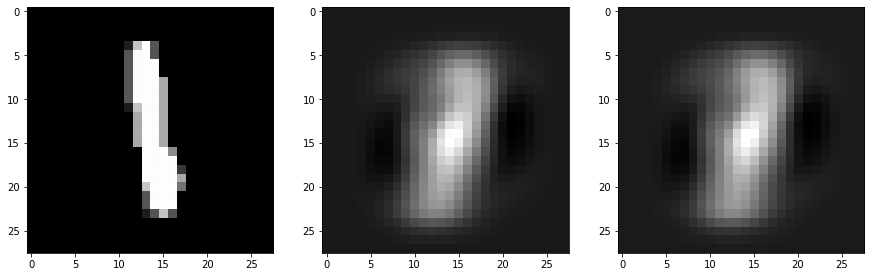

In [57]:
data = np.array(train_data)
data = data.reshape((data.shape[0],28, 28))

fig=plt.figure(figsize=(15, 15))

fig.add_subplot(1, 3, 1)
plt.imshow(data[200,:,:], cmap= 'gray')

#can send train_data in both if we want to just reduce dimensionality, if want to test, send different dataframe 
# as the second argument, the third argument is the number of dimensions to which we want to reduce the data/ number 
# of principal components
recon_2,new_2 = pca(train_data, train_data,2)
fig.add_subplot(1, 3, 2)
plt.imshow(recon_2[200,:].reshape(28,28), cmap= 'gray')
err2 = error(train_data,recon_2)
print("Reconstruction Error for k=2 ", err2)

recon_3,new_3 = pca(train_data, train_data,3)
fig.add_subplot(1, 3, 3)
plt.imshow(recon_3[200,:].reshape(28,28), cmap= 'gray')
err3 = error(train_data,recon_3)
print("Reconstruction Error for k=3 :", err3)

plt.show()


### Original images

In [13]:
def show_images(X_data, y_label):
    num_samples_per_class = 5
    num_class = 10
    fig,axs = plt.subplots(nrows=num_samples_per_class,ncols=num_class,figsize=(20,10))

    for class_idx in range(num_class):
        X_class = X_data[y_label==class_idx].reshape(-1,28,28)
        choose = np.random.choice(range(len(X_class)),num_samples_per_class,replace=False)
        X_sample = X_class[choose]
        for sample_idx in range(num_samples_per_class):
            axs[sample_idx,class_idx].imshow(X_sample[sample_idx],cmap='gray')
            axs[sample_idx,class_idx].axis('off')
            if sample_idx==0:
                axs[sample_idx,class_idx].set_title("Class: {}".format(class_idx))

    #plt.savefig(assets_dir+"class_sample_visualisation.png",dpi=300)
    plt.show()


In [14]:
X_train = np.array(train_data)
y_train = np.array(train_labels)

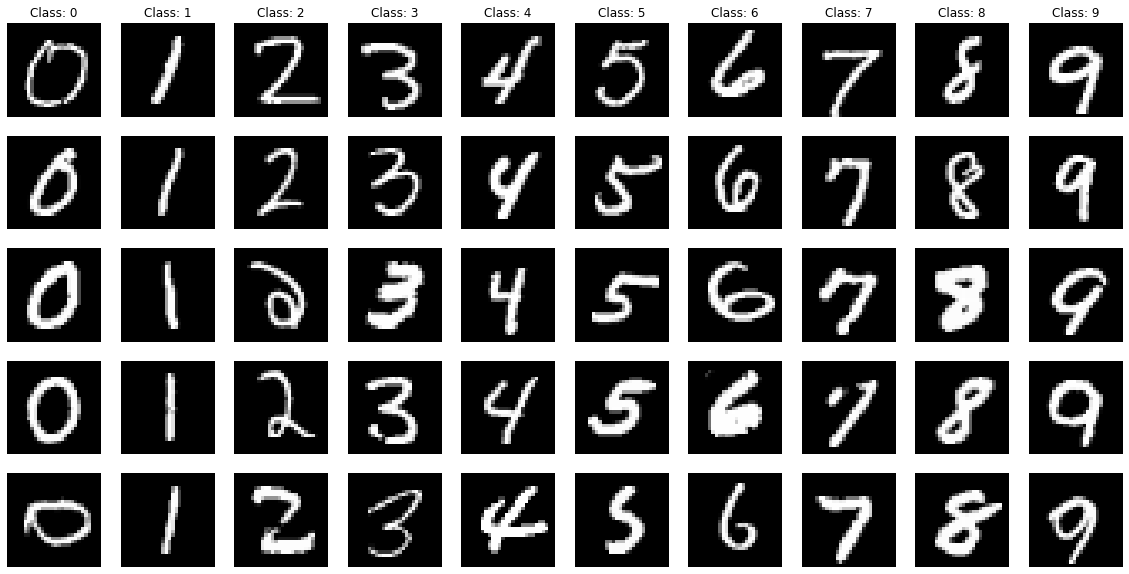

In [47]:
X_train = np.array(train_data)
y_train = np.array(train_labels)
show_images(X_train, y_train)


### Visualizing for different Ks

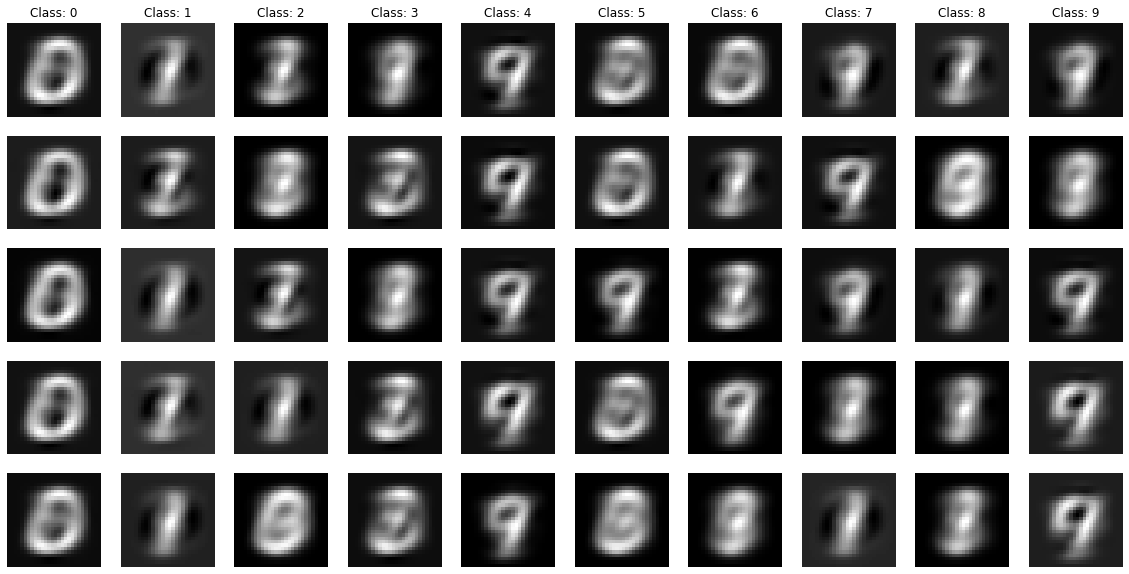

In [45]:
# k = 2

testing,new = pca(train_data, train_data,2)
testing = testing.reshape((testing.shape[0],28, 28))
show_images(testing, y_train)


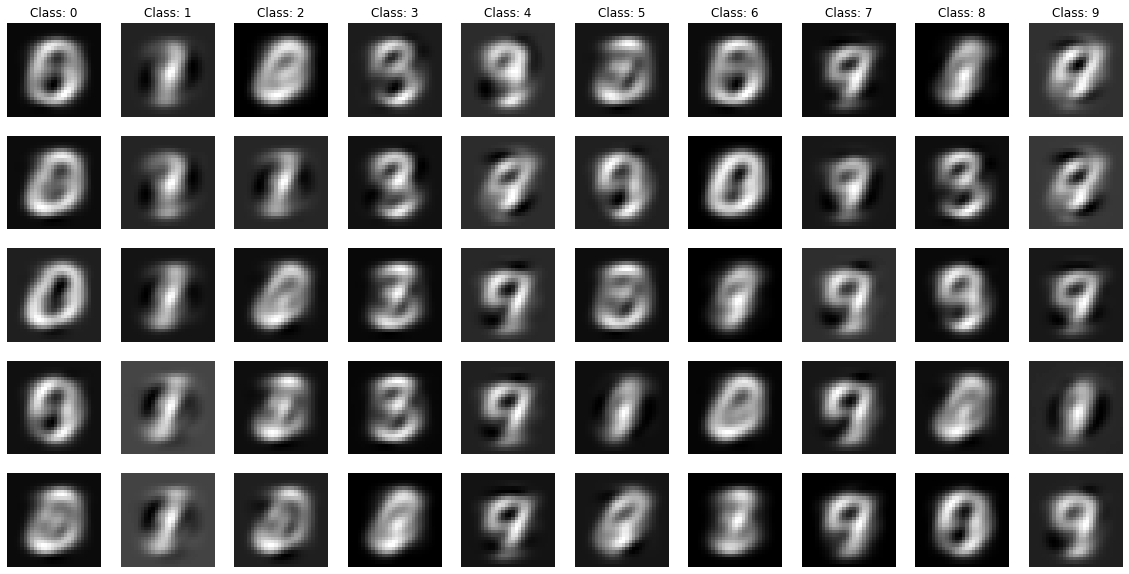

In [46]:
# k = 3

testing,new = pca(train_data, train_data,3)
testing = testing.reshape((testing.shape[0],28, 28))
show_images(testing, y_train)


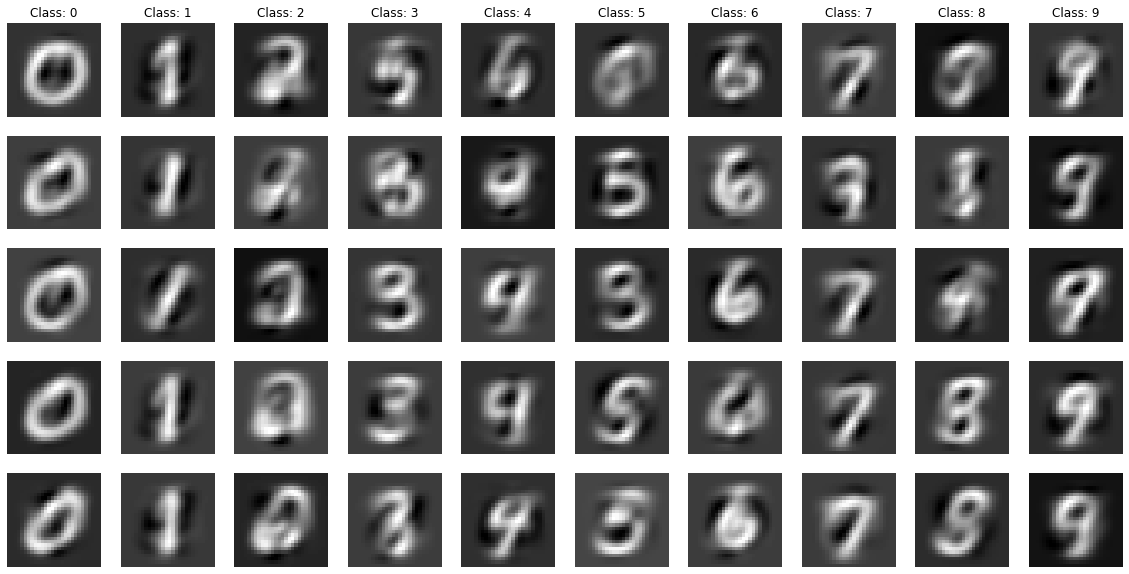

In [47]:
# k = 10

testing,new = pca(train_data, train_data,10)
testing = testing.reshape((testing.shape[0],28, 28))
show_images(testing, y_train)


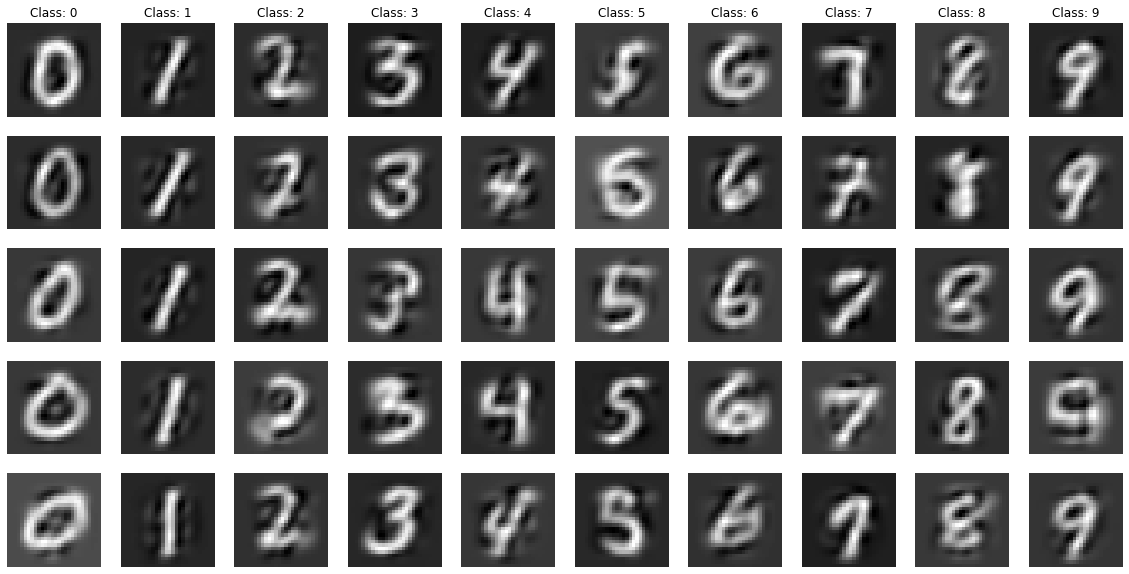

In [48]:
# k = 30

testing,new = pca(train_data, train_data,30)
testing = testing.reshape((testing.shape[0],28, 28))
show_images(testing, y_train)


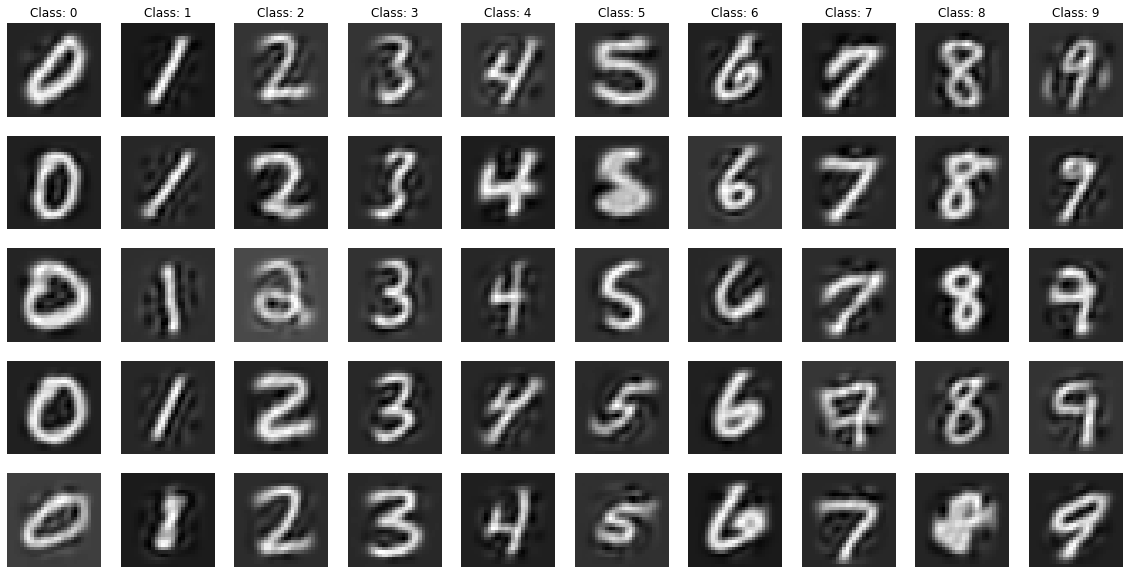

In [49]:
# k = 60

testing,new = pca(train_data, train_data,60)
testing = testing.reshape((testing.shape[0],28, 28))
show_images(testing, y_train)


# Visualizations

### MNIST

In [9]:
mnist_data = train_data
mnist_label = train_labels
%matplotlib notebook
from visualize import visualize_2d, visualize_3d

In [7]:
_,pca_mnist_2 = pca(mnist_data, mnist_data,2)

<IPython.core.display.Javascript object>


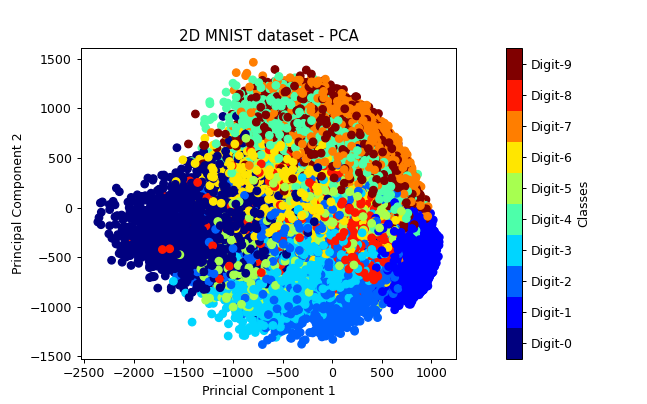

In [8]:
visualize_2d(pca_mnist_2, mnist_label, "2D MNIST dataset - PCA", ["Digit-0", "Digit-1", "Digit-2", "Digit-3", 
                                                                             "Digit-4","Digit-5","Digit-6","Digit-7",
                                                                             "Digit-8","Digit-9"], "2d_plots/pca_mnist.png", 
                                                                         "Princial Component 1", "Principal Component 2")

In [9]:
_,pca_mnist_3 = pca(mnist_data, mnist_data,3)

<IPython.core.display.Javascript object>


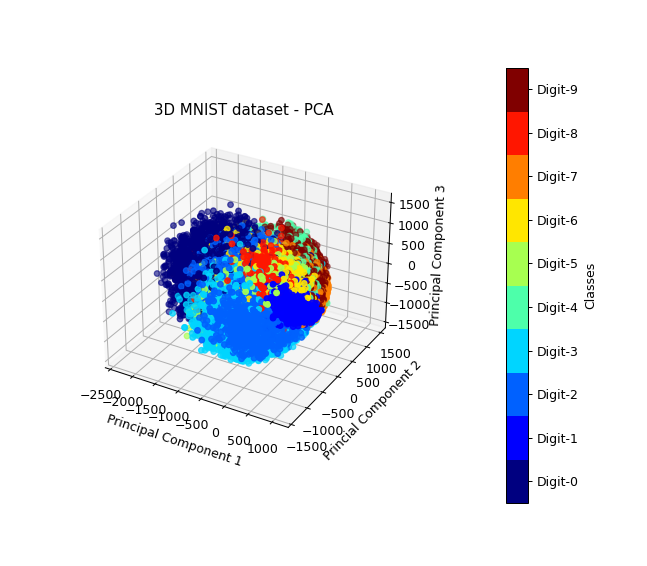

In [12]:
visualize_3d(pca_mnist_3, mnist_label, "3D MNIST dataset - PCA", ["Digit-0", "Digit-1", "Digit-2", "Digit-3", 
                                                                             "Digit-4","Digit-5","Digit-6","Digit-7",
                                                                             "Digit-8","Digit-9"], "Principal Component 1", 
                                                                         "Princial Component 2", "Principal Component 3")

#### Fashion- MNIST

In [5]:
def load_data(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
fashion_data, fashion_label = read_dataset(fa_data_filepath, fa_labels_filepath, dataset="mnist")

In [7]:
_,pca_fashion_2 = pca(fashion_data, fashion_data, 2)

<IPython.core.display.Javascript object>


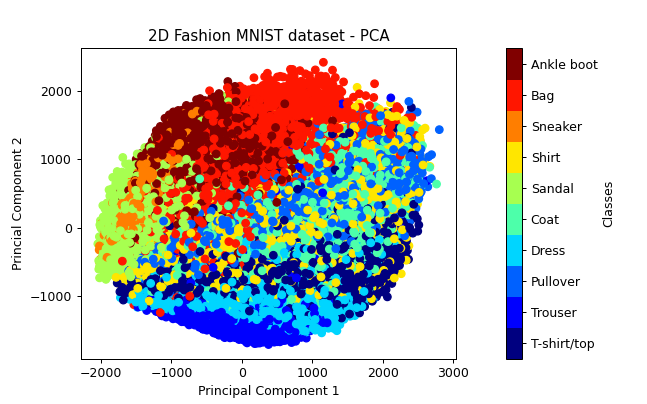

In [10]:
visualize_2d(pca_fashion_2, fashion_label, "2D Fashion MNIST dataset - PCA", ["T-shirt/top","Trouser","Pullover",
                                                                                   "Dress","Coat","Sandal","Shirt","Sneaker",
                                                                                   "Bag","Ankle boot"], "2d_plots/pca_fashion.png" ,
                                                                        "Principal Component 1", "Princial Component 2")

In [11]:
_,pca_fashion_3 = pca(fashion_data, fashion_data, 3)

<IPython.core.display.Javascript object>


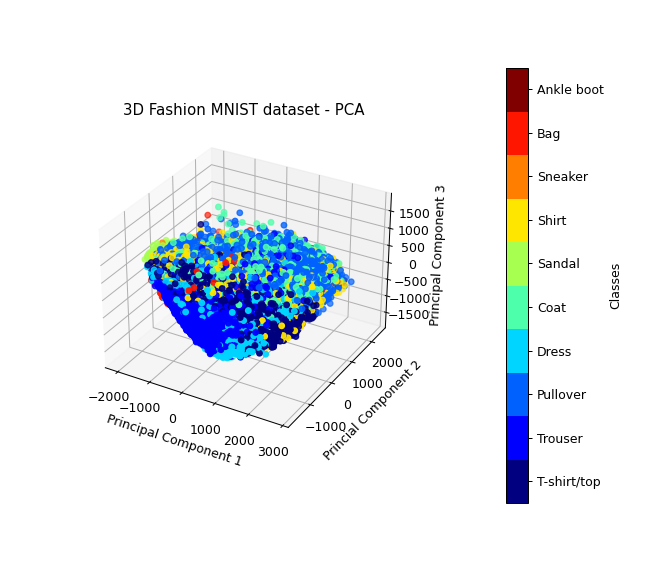

In [12]:
visualize_3d(pca_fashion_3, fashion_label, "3D Fashion MNIST dataset - PCA", ["T-shirt/top","Trouser","Pullover",
                                                                                   "Dress","Coat","Sandal","Shirt","Sneaker",
                                                                                "Bag","Ankle boot"],"Principal Component 1", 
                                                                         "Princial Component 2", "Principal Component 3")

### CIFAR-10

In [ ]:
cifar_data, cifar_label = read_dataset(cifar_data_filepath)

In [14]:
_, pca_cifar_2 = pca(cifar_data,cifar_data, 2)

<IPython.core.display.Javascript object>


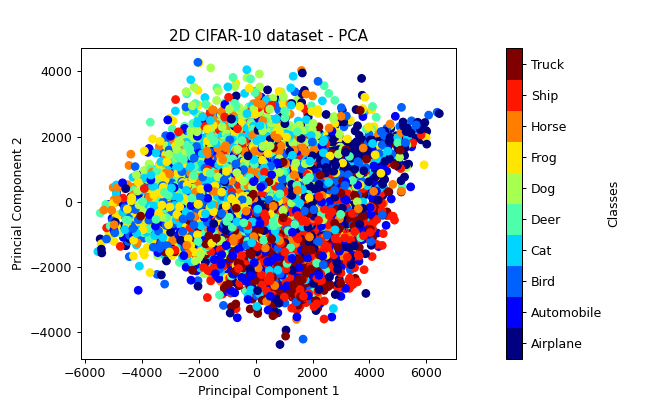

In [15]:
visualize_2d(pca_cifar_2,cifar_label, "2D CIFAR-10 dataset - PCA", ["Airplane", "Automobile", "Bird", "Cat", "Deer","Dog",
                                                                    "Frog", "Horse","Ship","Truck"], "2d_plots/pca_cifar.png",
                                                                     "Principal Component 1", "Princial Component 2")

In [ ]:
_, pca_cifar_3 = pca(cifar_data,cifar_data, 3)

In [ ]:
visualize_3d(pca_cifar_3, cifar_label, "3D CIFAR-10 dataset - PCA", ["Airplane", "Automobile", "Bird", "Cat", 
                                                                                "Deer","Dog","Frog", "Horse","Ship",
                                                                              "Truck"], "Principal Component 1", 
                                                                         "Princial Component 2", "Principal Component 3")

#### Reconstruction error vs number of components

In [57]:

li = []
for i in range(0, 785, 20):
    recon_data,new = pca(train_data, train_data,i)
    err = error(train_data,recon_data)
    li.append(err)


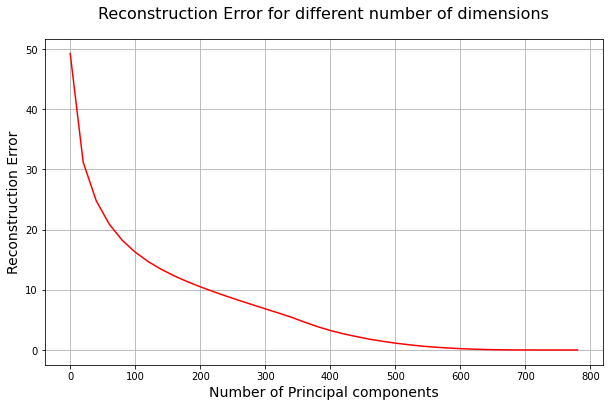

In [58]:

fig = plt.figure(figsize = (10,6))
plt.plot(np.arange(0, 785, 20), li, color = 'red')
plt.xlabel('Number of Principal components', fontsize = 14)
plt.ylabel('Reconstruction Error', fontsize = 14)
plt.title('Reconstruction Error for different number of dimensions',fontsize = 16,pad=20)
plt.grid(True)
plt.show()


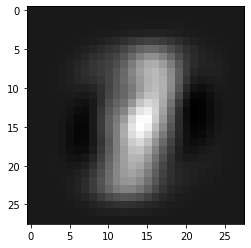

In [34]:
# comparing with sklearn's PCA
from sklearn.decomposition import PCA  
pca_sk = PCA(n_components=2)
reducedDF = np.array(pd.DataFrame(pca_sk.fit_transform(train_data.values)))
proj = pca_sk.inverse_transform(reducedDF)
plt.imshow(proj[200,:].reshape(28,28), cmap= 'gray');